In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import xlsxwriter
import pandas as pd # Excel
import struct # Binary writing

import scipy.io as sio # Read .mat files
import h5py

import time

from grading__old import *

from ipywidgets import FloatProgress
from IPython.display import display

import scipy.signal
import scipy.ndimage

import sklearn.metrics as skmet
import sklearn.decomposition as skdec
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def pipeline_lbp(impath, savepath, save, dtype='dat'):
    #Start time
    start_time = time.time()
    # Calculate MRELBP from dataset
    # Parameters
    dict = {'N':8, 'R':9,'r':3,'wc':5,'wr':(5,5)}
    mapping = getmapping(dict['N']) # mapping

    files = os.listdir(impath)
    files.sort()
    #print(files[32 * 2])
    #files.pop(32 * 2)
    #files.pop(32 * 2)
    #print(files)

    features = None # Reset feature array

    p = FloatProgress(min=0, max=len(files), description='Features:')
    display(p)
    for k in range(len(files)):
        #Load file
        if dtype == 'dat':
            p.value += 2
            if k > len(files) / 2 - 1:
                break
            file = os.path.join(impath,files[2 * k])
            try:
                Mz = loadbinary(file, np.float64)
            except:
                continue
            file = os.path.join(impath,files[2 * k + 1])
            try:
                sz = loadbinary(file, np.float64)
            except:
                continue
        else:
            file = os.path.join(impath,files[k])
            p.value += 1
            try:
                file = sio.loadmat(file)
                Mz = file['Mz']
                sz = file['sz']
            except NotImplementedError:
                file = h5py.File(file)
                Mz = file['Mz'][()]
                sz = file['sz'][()]
            
        #Combine mean and sd images
        image = Mz+sz
        #Grayscale normalization
        image = localstandard(image,23,5,5,1)
        # LBP
        Chist,Lhist,Shist,Rhist, lbpIL, lbpIS, lbpIR = MRELBP(image,dict['N'],dict['R'],dict['r'],dict['wc'],dict['wr'])
        f1 = Chist
        f2 = maplbp(Lhist,mapping)
        f3 = maplbp(Shist,mapping)
        f4 = maplbp(Rhist,mapping)
        #Concatenate features
        f = np.concatenate((f1.T,f2.T,f3.T,f4.T),axis=0)
        try:
            features = np.concatenate((features,f),axis=1)
        except ValueError:
            features = f
        # Save images
        if dtype == 'dat':
            cv2.imwrite(savepath + '\\' + files[2 * k][:-9] + '.png', lbpIS)
        else:
            cv2.imwrite(savepath + '\\' + files[k][:-9] + '.png', lbpIS)

        # Plot LBP images
        #plt.imshow(lbpIS); plt.show()
        #plt.imshow(lbpIL); plt.show()
        #plt.imshow(lbpIR); plt.show()

    # Save features
    writer = pd.ExcelWriter(save + r'\LBP_features_python.xlsx')
    df1 = pd.DataFrame(features)
    df1.to_excel(writer, sheet_name='LBP_features')
    writer.save()
    
    t = time.time()-start_time
    print('Elapsed time: {0}s'.format(t))
    
    
def pipeline_load(featurepath, gpath, save, choice):
    #Start time
    start_time = time.time()
    # Load grades to array
    grades = pd.read_excel(gpath, 'Sheet1')
    grades = pd.DataFrame(grades).values
    fnames = grades[:,0].astype('str')
    g = list(grades[:,choice].astype('int'))
    #g.pop(32)
    g = np.array(g)
    print('Max grade: {0}, min grade: {1}'.format(max(g), min(g)))
    
    # Load features
    features = pd.read_excel(featurepath, 'LBP_features')
    features = pd.DataFrame(features).values.astype('int')
    print(features.shape)
    
    #PCA
    # PCA parameters: whitening, svd solver (auto/full)
    pca, score = ScikitPCA(features.T, 10, True, 'auto')
    #pca, score = PCA(features,10)
    print(score[0,:])
    print(score.shape)

    # Regression
    if min(g) > 0:
        g = g - min(g)
    pred1 = regress(score, g)
    pred2 = logreg(score, g>min(g))
    for p in range(len(pred1)):
        if pred1[p]<0:
            pred1[p] = 0
        if pred1[p] > max(g):
            pred1[p]=max(g)

    #Plotting PCA
    a = g
    b = np.round(pred1).astype('int')

    # ROC curve
    C1 = skmet.confusion_matrix(a,b)
    MSE1 = skmet.mean_squared_error(a,pred1)
    fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
    AUC1 = skmet.auc(fpr,tpr)
    AUC2 = skmet.roc_auc_score(a>0,pred2)
    m, b = np.polyfit(a, pred1.flatten(), 1)
    R2 = skmet.r2_score(a,pred1.flatten())
    fig0  = plt.figure(figsize=(6,6))
    ax0 = fig0.add_subplot(111)
    ax0.plot(fpr,tpr)
    
    # Save prediction
    stats = np.zeros(len(g))
    stats[0] = MSE1
    stats[1] = AUC1
    stats[2] = AUC2
    tuples = list(zip(fnames, g, pred1[:,0], abs(g - pred1[:,0]), pred2, stats))
    writer = pd.ExcelWriter(save + r'\prediction_python.xlsx')
    df1 = pd.DataFrame(tuples, columns=['Sample', 'Actual grade', 'Prediction', 'Difference', 'Logistic prediction', 'MSE, AUC1, AUC2'])
    df1.to_excel(writer, sheet_name='Prediction')
    writer.save()

    print('Confusion matrix')
    print(C1)
    print('Mean squared error, Area under curve 1 and 2')
    print(MSE1, AUC1, AUC2)#,MSE2,MSE3,MSE4)
    print('R2 score')
    print(R2)
    #print('Sample, grade, prediction')
    #for k in range(len(fnames)):
    #    print(fnames[k],a[k],pred1[k])#,pred3[k])
    
    x = score[:,0]
    y = score[:,1]
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
    ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')
    for k in range(len(g)):
        txt = fnames[k][0:-4]+str(g[k])
        if g[k] >= 2:
            ax1.scatter(x[k],y[k],marker='s',color='r')
        else:
            ax1.scatter(x[k],y[k],marker='o',color='b')

    # Scatter plot actual vs prediction
    fig = plt.figure(figsize=(6,6))
    ax2 = fig.add_subplot(111)
    ax2.scatter(a,pred1.flatten())
    ax2.plot(a,m*a,'-',color='r')
    ax2.set_xlabel('Actual grade')
    ax2.set_ylabel('Predicted')
    for k in range(len(g)):
        txt = fnames[k]
        txt = txt+str(g[k])
        ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
    plt.show()

### Load features

Max grade: 3, min grade: 0
(32, 36)
[-0.61126449  1.55888136  0.81372917  0.47258567 -1.55170516 -1.5287743
 -0.89660894  2.45591342 -0.47300054  0.49480033]
(36, 10)
Confusion matrix
[[ 5  3  0  0]
 [ 1  7  3  0]
 [ 0  1 10  2]
 [ 0  1  3  0]]
Mean squared error, Area under curve 1 and 2
0.36308781086036107 0.7946428571428572 0.9464285714285714
R2 score
0.5953896793851865


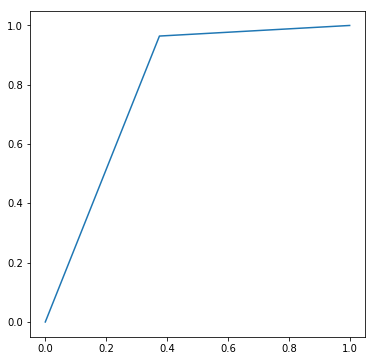

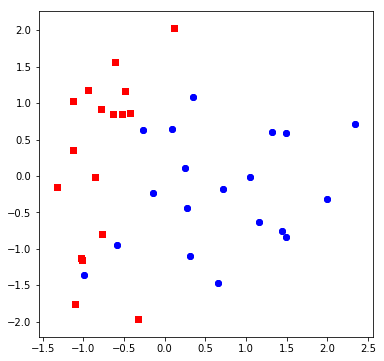

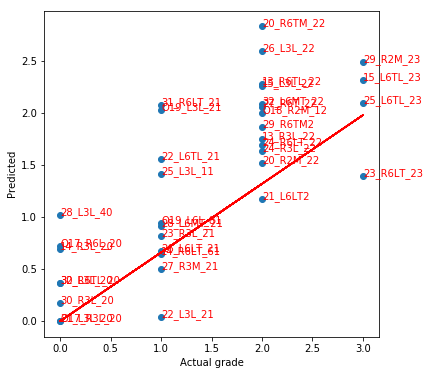

In [8]:
featurepath = r'Z:\3DHistoData\Grading\LBP_features_surface.xlsx'
gpath = r'Z:\3DHistoData\Grading\PTAgreiditjanaytteet.xls'
save = r'Z:\3DHistoData\Grading'

total = 1
surf = 2
deep = 5
cc = 6
deepcell = 7
deepECM = 8
ccECM = 9
ccVasc = 10

choice = surf
pipeline_load(featurepath, gpath, save, choice)

### Calculate LBP features from .dat mean and std images

In [4]:
impath = r'Z:\3DHistoData\SurfaceImages\Deep'
impath = r'V:\Tuomas\PTASurfaceImages'
dtype = 'dat'
dtype = 'mat'
savepath = r'Z:\3DHistoData\Grading\LBP'
save = r'Z:\3DHistoData\Grading'


pipeline_lbp(impath, savepath, save, dtype)

FloatProgress(value=0.0, description='Features:', max=36.0)

Elapsed time: 52.08493900299072s
